In [ ]:
import torch
import torchtext
from torchtext import datasets
from torchtext import data
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import re
import os
import numpy as np
import pandas as pd
import spacy
import time
import matplotlib.pyplot as plt
from collections import Counter
from torchtext.vocab import vocab
from torchtext.vocab import GloVe
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torch.optim as optim

In [ ]:
print("PyTorch Version : {}".format(torch.__version__))
print("Torch Text Version : {}".format(torchtext.__version__))



PyTorch Version : 1.13.0
Torch Text Version : 0.14.0


In [ ]:
SEED = 100
torch.manual_seed(SEED)

In [ ]:
device = torch.device("mps")
# device = torch.device("cpu")


In [ ]:
class ReadDataSet(torch.utils.data.Dataset):
     def __init__(self,file):
        super(ReadDataSet).__init__()
        csv=pd.read_csv(file,dtype={'target': np.float32, 'text': str})
        csv=csv[csv["text"].notnull()]
        self.data=csv
     def __len__(self):
        return self.data.shape[0]
    
     def __getitem__(self,idx):
        return  self.data['target'].iloc[idx],self.data['text'].iloc[idx]


In [ ]:
train_dataset=ReadDataSet('./train_preprocessing.csv')         
test_dataset=ReadDataSet('./test_preprocessing.csv')         
valid_dataset=ReadDataSet('./valid_preprocessing.csv')         


In [ ]:
print(f'train dataset size:{len(train_dataset)}, test dataset size:{len(test_dataset)}, validate dataset size:{len(valid_dataset)} ')



train dataset size:955899, test dataset size:318646, validate dataset size:318602 


In [ ]:
tokenizer = get_tokenizer("basic_english")


In [ ]:
global_vectors = GloVe(name='twitter.27B', dim=200)



In [ ]:
model=2
if model==1:
    # fc1  self.fc1 = nn.Linear(n_filters*(nrow1+nrow2+nrow3), 10)
    # fc2: self.fc2 = nn.Linear(10, 1)
    max_words = 200
    embed_len = 200
    batch_size=100
    n_filters=32
    filters=[3,4,5]
elif model==2:
    # self.fc1 = nn.Linear(n_filters*(nrow1+nrow2+nrow3), 1)
    # no fc2
    max_words = 200
    embed_len = 200
    batch_size=100
    n_filters=32
    filters=[3,4,5]
elif model==3:    
    # self.fc1 = nn.Linear(n_filters*(nrow1+nrow2+nrow3), 1)
    # no fc2
    max_words = 200
    embed_len = 200
    batch_size=100
    n_filters=100
    filters=[3,4,5]


def vectorize_batch(batch):
    Y, X = list(zip(*batch))
    
    
    X = [tokenizer(x) for x in X]
    X = [tokens+[""] * (max_words-len(tokens))  if len(tokens)<max_words else tokens[:max_words] for tokens in X]
    X_tensor = torch.zeros(len(batch),1, max_words, embed_len)
    for i, tokens in enumerate(X):
        X_tensor[i] = global_vectors.get_vecs_by_tokens(tokens)
    return X_tensor, torch.tensor(Y) 

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=vectorize_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=vectorize_batch)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False,collate_fn=vectorize_batch)



In [ ]:

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        #input is [100,1,200,200] : batch size, 1,max words, embedding length
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=n_filters, kernel_size=(filters[0],embed_len))
        self.pool = nn.MaxPool1d(2, 2)
        nrow1=int((max_words-filters[0]+1)/2)
        
        self.conv2 = nn.Conv2d(in_channels=1,out_channels=n_filters, kernel_size=(filters[1],embed_len))
        nrow2=int((max_words-filters[1]+1)/2)
        
        self.conv3 = nn.Conv2d(in_channels=1,out_channels=n_filters, kernel_size=(filters[2],embed_len))
        nrow3=int((max_words-filters[2]+1)/2)
        
        if model==1:
            self.fc1 = nn.Linear(n_filters*(nrow1+nrow2+nrow3), 10)
            self.fc2 = nn.Linear(10, 1)
        elif model==2:
            self.fc1 = nn.Linear(n_filters*(nrow1+nrow2+nrow3), 1)
        elif model==3:
            self.fc1 = nn.Linear(n_filters*(nrow1+nrow2+nrow3), 1)
        
    def forward(self, x):
        t=self.conv1(x)
        x1 = self.pool(F.relu(self.conv1(x).squeeze(3)))
        x2 = self.pool(F.relu(self.conv2(x).squeeze(3)))
        x3 = self.pool(F.relu(self.conv3(x).squeeze(3)))
        x=torch.cat((x1, x2, x3),dim=2)
        x = torch.flatten(x,1) # flatten all dimensions except batch
        if model==1:
            x = F.relu(self.fc1(x))
            x = self.fc2(x)
        elif model==2:
            x = self.fc1(x)
        elif model==3:                
            x = self.fc1(x)
        x=torch.flatten(x)
        
        return x

net = Net()

net.to(device)


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 200), stride=(1, 1))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(1, 32, kernel_size=(4, 200), stride=(1, 1))
  (conv3): Conv2d(1, 32, kernel_size=(5, 200), stride=(1, 1))
  (fc1): Linear(in_features=9440, out_features=1, bias=True)
)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9)

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #  inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f}')
            running_loss = 0.0
    PATH = f'./model{model}/net.epoch{epoch+1}.pth'
    torch.save(net.state_dict(), PATH)

print('Finished Training')

[1,  1000] loss: 0.543
[1,  2000] loss: 0.510
[1,  3000] loss: 0.500
[1,  4000] loss: 0.492
[1,  5000] loss: 0.491
[1,  6000] loss: 0.486
[1,  7000] loss: 0.483
[1,  8000] loss: 0.480
[1,  9000] loss: 0.477
[2,  1000] loss: 0.465
[2,  2000] loss: 0.466
[2,  3000] loss: 0.466
[2,  4000] loss: 0.466
[2,  5000] loss: 0.466
[2,  6000] loss: 0.468
[2,  7000] loss: 0.463
[2,  8000] loss: 0.466
[2,  9000] loss: 0.467
[3,  1000] loss: 0.449
[3,  2000] loss: 0.447
[3,  3000] loss: 0.452
[3,  4000] loss: 0.454
[3,  5000] loss: 0.453
[3,  6000] loss: 0.452
[3,  7000] loss: 0.456
[3,  8000] loss: 0.454
[3,  9000] loss: 0.456
[4,  1000] loss: 0.435
[4,  2000] loss: 0.433
[4,  3000] loss: 0.440
[4,  4000] loss: 0.440
[4,  5000] loss: 0.445
[4,  6000] loss: 0.440
[4,  7000] loss: 0.443
[4,  8000] loss: 0.445
[4,  9000] loss: 0.444
[5,  1000] loss: 0.422
[5,  2000] loss: 0.425
[5,  3000] loss: 0.425
[5,  4000] loss: 0.432
[5,  5000] loss: 0.430
[5,  6000] loss: 0.431
[5,  7000] loss: 0.432
[5,  8000] 

In [ ]:
net = Net()
accuracy_training=[]
loss_training=[]
accuracy_validation=[]
loss_validation=[]

for i in range(10):
    PATH = f'./model{model}/net.epoch{i+1}.pth'
    net.load_state_dict(torch.load(PATH))
    
    correct = 0
    running_loss=0.
    total = 0
    with torch.no_grad():
        for data in train_loader:
            texts, labels = data
            # calculate outputs by running images through the network
            total += labels.size(0)
            outputs = net(texts)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            sigmoids=torch.sigmoid(outputs)
            sigmoids=(sigmoids>0.5)+0
            correct += (sigmoids.data == labels).sum().item()
        accuracy_training.append(100*correct/total)
        loss_training.append(running_loss/total)
       
    correct = 0
    running_loss=0.
    total = 0
    with torch.no_grad():
        for data in valid_loader:
            texts, labels = data
            # calculate outputs by running images through the network
            total += labels.size(0)
            outputs = net(texts)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            sigmoids=torch.sigmoid(outputs)
            sigmoids=(sigmoids>0.5)+0
            correct += (sigmoids.data == labels).sum().item()
        accuracy_validation.append(100*correct/total)
        loss_validation.append(running_loss/total)
       
print(accuracy_training)
print(loss_training)
print(accuracy_validation)
print(loss_validation)


[76.44782555479188, 78.3143407410197, 78.86303887753832, 79.41717691931888, 79.75800790669307, 80.13545364102275, 80.14968108555402, 80.66845974313186, 80.89578501494405, 80.92643678882392]
[0.00482585873656912, 0.004586811509165523, 0.004500546337448413, 0.004423047891995903, 0.004365933688051353, 0.004295599820587051, 0.004267854985580404, 0.0042101038756594085, 0.004173790762286987, 0.004159882058500796]
[76.07736297951676, 77.48476155203043, 77.65676298328322, 77.80302697409307, 77.68532526475038, 77.77980050344945, 77.53560869046647, 77.66900396105486, 77.80302697409307, 77.46812637711]
[0.004900473657336443, 0.004728646861320842, 0.004714502350057414, 0.00470618280860233, 0.004718458318892021, 0.004737241146753077, 0.004764525194974668, 0.004790195051134173, 0.004787030769476103, 0.004825190173345703]


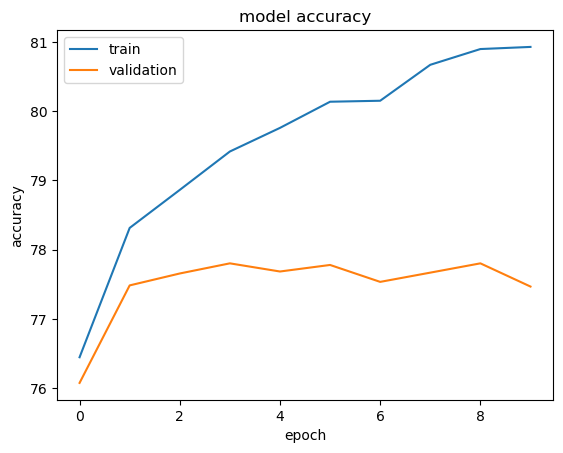

In [ ]:
from matplotlib import pyplot as plt
plt.plot(accuracy_training)
plt.plot(accuracy_validation)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

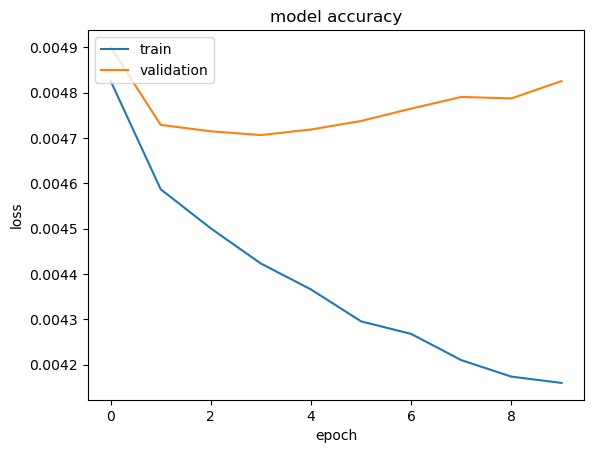

In [ ]:
plt.plot(loss_training)
plt.plot(loss_validation)
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
#test dataset
net = Net()

PATH = f'./model{model}/net.epoch{1+1}.pth'
net.load_state_dict(torch.load(PATH))

correct = 0
running_loss=0.
total = 0
with torch.no_grad():
    for data in test_loader:
        texts, labels = data
        total += labels.size(0)
        outputs = net(texts)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        sigmoids=torch.sigmoid(outputs)
        sigmoids=(sigmoids>0.5)+0
        correct += (sigmoids.data == labels).sum().item()
accuracy=100*correct/total
loss=running_loss/total

print(f'accuracy of test data is: {accuracy:.1f}')
print(f'loss of test data is: {loss:.5f}')


accuracy of test data is: 77.4
loss of test data is: 0.00473
